**Download Data**

Unzip the dataset into the folder "dataset".

In [1]:
!rm -vrf "dataset"
!mkdir "dataset"
!cp -r "cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
!unzip "dataset/cervigram-image-dataset-v2.zip" -d "dataset"

Archive:  dataset/cervigram-image-dataset-v2.zip
   creating: dataset/data/
   creating: dataset/data/test/
   creating: dataset/data/test/0/
   creating: dataset/data/test/0/20151103002/
  inflating: dataset/data/test/0/20151103002/20151103113458.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113637.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113659.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113722.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113752.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113755.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113833.jpg  
   creating: dataset/data/test/0/20151103005/
  inflating: dataset/data/test/0/20151103005/20151103161719.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161836.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161908.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161938.jpg  
  inflating: dataset/data/test/0/2015110

Download dependencies.

pip3 install torch==1.3.1+cu92 torchvision==0.4.2+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [18]:
!pip3 install torch torchvision

     |████████████████████████████████| 10.2MB 8.9MB/s eta 0:00:01 | 5.9MB 8.9MB/s eta 0:00:01████████████████████       | 7.9MB 8.9MB/s eta 0:00:01��██▋| 10.0MB 8.9MB/s eta 0:00:01
     |████████████████████████████████| 2.1MB 42.0MB/s eta 0:00:01


In [5]:
!pip3 install matplotlib sklearn

     |████████████████████████████████| 13.1MB 23.1MB/s eta 0:00:01    |███████████████████             | 7.8MB 23.1MB/s eta 0:00:01██████████████████████▉  | 12.3MB 23.1MB/s eta 0:00:01
     |████████████████████████████████| 92kB 6.1MB/s  eta 0:00:01
     |████████████████████████████████| 71kB 4.9MB/s  eta 0:00:01
     |████████████████████████████████| 6.7MB 56.1MB/s eta 0:00:01�█████████████████        | 5.0MB 56.1MB/s eta 0:00:01
     |████████████████████████████████| 296kB 54.8MB/s eta 0:00:01
     |████████████████████████████████| 25.2MB 23.4MB/s eta 0:00:01|███████████▏                    | 8.8MB 23.4MB/s eta 0:00:0123.4MB/s eta 0:00:01     |█████████████████▌              | 13.8MB 23.4MB/s eta 0:00:01     |███████████████████▌            | 15.4MB 23.4MB/s eta 0:00:01     |███████████████████████████▉    | 22.0MB 23.4MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=9fbe2375f65a29c62f18ff722297cd286c797778679ee7523629700

**Constants**

In [253]:
TRAIN_PATH = 'dataset/data/train/'
TEST_PATH = 'dataset/data/test/'

CROP_SIZE = 260
IMAGE_SIZE = 224
BATCH_SIZE = 128

**Imports**

In [254]:
import torch as t
import torchvision as tv
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Linear, BCEWithLogitsLoss
import sklearn as sk
import sklearn.metrics
from os import listdir
import time
import random

**Deterministic Measurements**

This statements help making the experiments reproductible by fixing the random seeds.

In [255]:
SEED = 0
t.manual_seed(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

**Loading Data**

The dataset is structured in multiple small folders, ecah containing 7 images. The generator iterates through the folders and returns the category and 7 paths: one for each image in the folder.

In [256]:
def sortByLastDigits(elem):
  chars = [c for c in elem if c.isdigit()]
  return 0 if len(chars) == 0 else int(''.join(chars))

def getImagesPaths(root_path):
  for  class_folder in [root_path + f for f in listdir(root_path)]:
      category = int(class_folder[-1])
      for case_folder in listdir(class_folder):
        case_folder_path = class_folder + '/' + case_folder + '/'
        img_files = [case_folder_path + file_name for file_name in listdir(case_folder_path)]
        yield category, sorted(img_files, key = sortByLastDigits)

We define 3 datasets, which loads 3 kinds of images: natural images, images taken through a green lens and images where the doctor aplied iodine solution (which gives a dark red colour). Each dataset has dynamic and static transformations which could be applied to the data. The static transformations are applied on the initialization of the dataset, while the dynamic ones are applied when loading each batch of data.

In [257]:
class SimpleImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      for i in range(5):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      x = self.transforms_x(x)
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

class GreenLensImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-2]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class RedImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-1]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

**Preprocess Data**

Convert pytorch tensor to numpy array.

In [258]:
def to_numpy(x):
  return x.cpu().detach().numpy()

Data transformations for the test and training sets.

In [259]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

transforms_train = tv.transforms.Compose([
    tv.transforms.RandomAffine(degrees  = 45, translate = None, scale = (1., 2.), shear = 30),
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda t: t.cuda()),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

transforms_test = tv.transforms.Compose([
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

y_transform = tv.transforms.Lambda(lambda y: t.tensor(y, dtype=t.long, device = 'cuda:0'))

Initialize pytorch datasets and loaders for training and test.

In [260]:
def create_loaders(dataset_class):
  dataset_train = dataset_class(TRAIN_PATH, transforms_x_dynamic = transforms_train, transforms_y_dynamic = y_transform)
  dataset_test = dataset_class(TEST_PATH, transforms_x_static = transforms_test, 
                                                transforms_x_dynamic = tv.transforms.Lambda(lambda t: t.cuda()), transforms_y_dynamic = y_transform)

  loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True)
  loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = False)
  return loader_train, loader_test, len(dataset_train), len(dataset_test)

In [261]:
loader_train_simple_img, loader_test_simple_img, len_train, len_test = create_loaders(SimpleImagesDataset)

**Visualize Data**

Load a few images so that we can see the efects of the data augmentation on the training set.

In [262]:
def plot_one_prediction(x, label, pred):  
  x, label, pred = to_numpy(x), to_numpy(label), to_numpy(pred)
  x = np.transpose(x, [1, 2, 0])
  if x.shape[-1] == 1:
    x = x.squeeze()
  x = x * np.array(norm_std) + np.array(norm_mean)
  plt.title(label, color = 'green' if label == pred else 'red')
  plt.imshow(x)

def plot_predictions(imgs, labels, preds):  
  fig = plt.figure(figsize = (20, 5))
  for i in range(20):
    fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
    plot_one_prediction(imgs[i], labels[i], preds[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

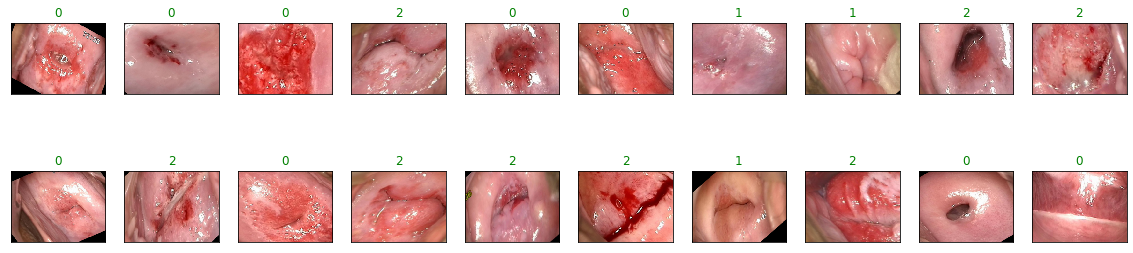

In [294]:
x, y = next(iter(loader_train_simple_img))
plot_predictions(x, y, y)

**Model**

Define a few models to experiment with.

In [264]:
def get_mobilenet_v2():
  model = t.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
  model.classifier[0] = t.nn.Dropout(p=0.9, inplace=False)
  model.classifier[1] = Linear(in_features=1280, out_features=4, bias=True)
  # model.features[18].add_module('cnn_drop_18', t.nn.Dropout2d(p = .3))
  # model.features[17]._modules['conv'][1].add_module('cnn_drop_17', t.nn.Dropout2d(p = .2))
  # model.features[16]._modules['conv'][1].add_module('cnn_drop_16', t.nn.Dropout2d(p = .1))
  model = model.cuda()
  return model

def get_vgg_19():
  model = tv.models.vgg19(pretrained = True)
  model = model.cuda()
  model.classifier[2].p = .9
  model.classifier[6].out_features = 4
  return model

def get_res_next_101():
  model = t.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
  model.fc = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features=2048, out_features=4)
  )
  model = model.cuda()
  return model

def get_resnet_18():
  model = tv.models.resnet18(pretrained = True)
  model.fc = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features=512, out_features=4)
  )
  model = model.cuda()
  return model

def get_dense_net():
  model = tv.models.densenet121(pretrained = True)
  model.classifier = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features = 1024, out_features = 4)
  )
  model = model.cuda()
  return model

Based on multiple experiments, I recommend the resnet 18 network as being most convenient (taking into account accuracy and size of the model).

In [265]:
model_simple = get_mobilenet_v2()

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


**Train & Evaluate**

Timer utility function. This is used to measure the execution speend.

In [266]:
time_start = 0

def timer_start():
  global time_start
  time_start = time.time()

def timer_end():
  return time.time() - time_start

This function trains the network and e valuates it at the same time. It outputs the metrics recorder during the training for both train and test. We are measuring accuracy and the loss. The function also saves a checkpoint of the model every time the accuracy is imporved. In the end we will have a checkpoint of the model which gave the best accuracy.

In [267]:
def train_eval(optimizer, model, loader_train, loader_test, chekpoint_name, epochs):
  metrics = {
      'losses_train': [],
      'losses_test': [],
      'acc_train': [],
      'acc_test': []
  }

  best_acc = 0
  loss_weights = t.tensor([1/4] * 4, device='cuda:0')

  for epoch in range(epochs):
    loss_fn = t.nn.CrossEntropyLoss(weight = loss_weights)
    # loss_fn = t.nn.CrossEntropyLoss()
    
    timer_start()
    train_epoch_acc, train_epoch_loss = 0, 0
    test_epoch_acc, test_epoch_loss = 0, 0

    # Train
    model.train()
    for x, y in loader_train:
      y_pred = model.forward(x)
      loss = loss_fn(y_pred, y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      pred = y_pred.argmax(axis = 1)
      ratio = len(y) / len_train
      train_epoch_loss += (loss * ratio)
      train_epoch_acc += (sk.metrics.classification.accuracy_score(y, pred) * ratio)
    metrics['losses_train'].append(train_epoch_loss)
    metrics['acc_train'].append(train_epoch_acc)

  
    # Evaluate
    model.eval()
    with t.no_grad():
      conf_matrix = np.zeros((4, 4))
      for x, y in loader_test:
        y_pred = model.forward(x)
        loss = loss_fn(y_pred, y)
        y_pred, y = to_numpy(y_pred), to_numpy(y)
        pred = y_pred.argmax(axis = 1)
        ratio = len(y) / len_test
        test_epoch_loss += (loss * ratio)
        test_epoch_acc += (sk.metrics.classification.accuracy_score(y, pred) * ratio )
        conf_matrix += sk.metrics.classification.confusion_matrix(y, pred, labels = list(range(4)))
      metrics['losses_test'].append(test_epoch_loss)
      metrics['acc_test'].append(test_epoch_acc)
      errors = [sum(conf_matrix[i]) - conf_matrix[i][i] for i in range(len(conf_matrix))]
      errors_strong = [e ** 3 for e in errors]
      loss_weights = t.tensor([e / sum(errors_strong) for e in errors_strong], device = 'cuda:0')  
#       loss_weights = t.softmax(t.tensor(errors), 0).cuda()
  
    if metrics['acc_test'][-1] > best_acc:
      best_acc = metrics['acc_test'][-1]
      t.save({'model': model.state_dict()}, 'checkpint {}.tar'.format(chekpoint_name))
    print('Epoch {} acc {} minutes {} errors {} loss weights {}'.format(epoch + 1, metrics['acc_test'][-1], timer_end() / 60, errors, loss_weights))
  print('Ended training')
  
  return metrics

Plot a metric for both train and test.

In [268]:
def plot_train_test(train, test, title):
    plt.plot(range(len(train)), train, label = 'train')
    plt.plot(range(len(test)), test, label = 'test')
    plt.title(title)
    plt.legend()
    plt.show()

Train a model for several epochs. The steps_learning parameter is a list of tuples. Each tuple specifies the steps and the learning rate.

In [269]:
def do_train(model, loader_train, loader_test, checkpoint_name, steps_learning):
  for steps, learn_rate in steps_learning:
    t.cuda.empty_cache()
    metrics = train_eval(t.optim.Adam(model.parameters(), lr = learn_rate), model, loader_train, loader_test, checkpoint_name, steps)
    print('Best test accuracy :', max(metrics['acc_test']))
    plot_train_test(metrics['losses_train'], metrics['losses_test'], 'Loss (lr = {})'.format(learn_rate))
    plot_train_test(metrics['acc_train'], metrics['acc_test'], 'Accuracy (lr = {})'.format(learn_rate))

Perform actual training

Epoch 1 acc 0.2833333333333333 minutes 0.6465077439943949 errors [60.0, 13.0, 56.0, 43.0] loss weights tensor([0.4564, 0.0046, 0.3710, 0.1680], device='cuda:0')
Epoch 2 acc 0.2916666666666667 minutes 0.39040268659591676 errors [59.0, 27.0, 42.0, 42.0] loss weights tensor([0.5503, 0.0527, 0.1985, 0.1985], device='cuda:0')
Epoch 3 acc 0.2625 minutes 0.3891156872113546 errors [59.0, 36.0, 38.0, 44.0] loss weights tensor([0.5238, 0.1190, 0.1399, 0.2173], device='cuda:0')
Epoch 4 acc 0.3375 minutes 0.3959324796994527 errors [35.0, 44.0, 33.0, 47.0] loss weights tensor([0.1601, 0.3181, 0.1342, 0.3877], device='cuda:0')
Epoch 5 acc 0.37083333333333335 minutes 0.38584975798924764 errors [18.0, 47.0, 38.0, 48.0] loss weights tensor([0.0212, 0.3774, 0.1994, 0.4020], device='cuda:0')
Epoch 6 acc 0.3916666666666666 minutes 0.39585724274317424 errors [19.0, 39.0, 41.0, 47.0] loss weights tensor([0.0287, 0.2483, 0.2885, 0.4345], device='cuda:0')
Epoch 7 acc 0.38333333333333336 minutes 0.389676312605

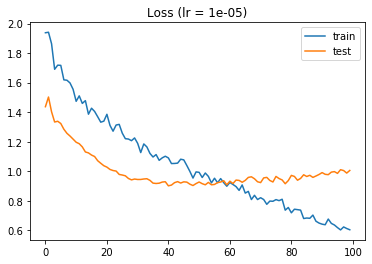

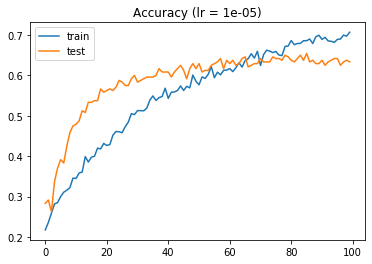

In [270]:
do_train(model_simple, loader_train_simple_img, loader_test_simple_img, 'simple_1', [(100, 1e-5)])

**Error distribution**

Analyze the confusion matrix and error distribution of trained model.

In [275]:
# Confusion matrix analysis
model_simple.eval()
with t.no_grad():
  conf_matrix = np.zeros((4, 4))
  for x, y in loader_test_simple_img:
    y_pred = model_simple.forward(x)
    y_pred, y = to_numpy(y_pred), to_numpy(y)
    pred = y_pred.argmax(axis = 1)
    cm = sk.metrics.classification.confusion_matrix(y, pred, labels = list(range(4)))
    conf_matrix += cm
  print('Confusion matrix:\n', conf_matrix)
  errors = [sum(conf_matrix[i]) - conf_matrix[i][i] for i in range(len(conf_matrix))]
  print('Error distribution:\n', errors)

Confusion matrix:
 [[46.  3.  9.  2.]
 [15. 33. 12.  0.]
 [12. 11. 35.  2.]
 [ 0.  1. 21. 38.]]
Error distribution:
 [14.0, 27.0, 25.0, 22.0]


Text(0, 0.5, 'Error percentage')

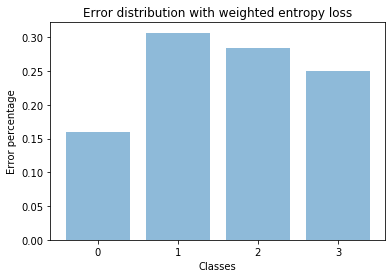

In [288]:
error_distribution = [e / sum(errors) for e in errors]
plt.bar(list(range(4)), error_distribution, align='center', alpha=0.5)
plt.xticks(list(range(4)), list(range(4)))
plt.title('Error distribution with weighted entropy loss')
plt.xlabel('Classes')
plt.ylabel('Error percentage')

Display error distribution for simple entropy loss.

Text(0, 0.5, 'Error percentage')

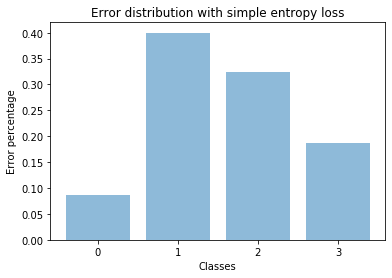

In [290]:
error_distribution = [0.0875, 0.4, 0.325, 0.1875]
plt.bar(list(range(4)), error_distribution, align='center', alpha=0.5)
plt.xticks(list(range(4)), list(range(4)))
plt.title('Error distribution with simple entropy loss')
plt.xlabel('Classes')
plt.ylabel('Error percentage')

Display distribution of training data.

Text(0, 0.5, 'Image count percentage')

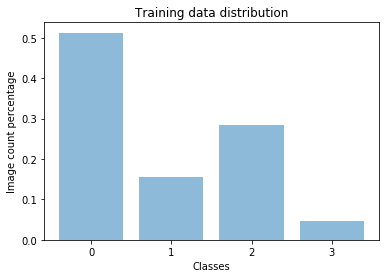

In [293]:
trainig_data_count = [1540 , 469, 854 , 140 ]
trainig_data_distirbution = [t / sum(trainig_data_count) for t in trainig_data_count]
plt.bar(list(range(4)), trainig_data_distirbution, align='center', alpha=0.5)
plt.xticks(list(range(4)), list(range(4)))
plt.title('Training data distribution')
plt.xlabel('Classes')
plt.ylabel('Image count percentage')